### Execution environment
Since Jupyter notebookes work from a different directory the code block below changes the execution path to the root of the prject

In [22]:
import client as cl
import os
dir = os.getcwd()
if dir.split("/")[-3] == "codebase":
    os.chdir("../../")

In [23]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tenseal as ts
import time


In [24]:
# importing module
import logging

# Create and configure logger
logging.basicConfig(
    filename="encrypted_evaluation.log", format="%(asctime)s %(message)s", filemode="a"
)


In [25]:
torch.random.manual_seed(61)

In [26]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out


In [27]:
def test_train_split(df):
    training_data = df.sample(frac=0.8, random_state=25)  #
    testing_data = df.drop(training_data.index)
    y_train, x_train = (
        training_data["YearsExperience"].to_numpy(),
        training_data["Salary"].to_numpy(),
    )
    y_test, x_test = (
        testing_data["YearsExperience"].to_numpy(),
        testing_data["Salary"].to_numpy(),
    )
    return x_train, y_train, x_test, y_test


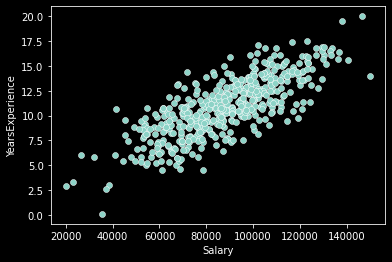

In [28]:
df = pd.read_csv("./LinearRegression/Data/Custom_Salary_Data.csv")
sns.scatterplot(data=df, x="Salary", y="YearsExperience")
plt.show()

In [29]:
x_train, y_train, x_test, y_test = test_train_split(df)
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


In [30]:
model = LinearRegressionModel(1, 1)  # single dimension
# criterion = nn.MSELoss(reduction = "mean") # mean squared error, minimise total loss
criterion = nn.L1Loss(reduction="mean")  # mean absolute error, minimise total loss
learning_rate = 5e-10
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate
)  # Stochastic Gradient Descent
EPOCHS = 100000
model = model.double()


In [31]:
# Convert numpy array to torch Variable
x_train_tensor = torch.from_numpy(x_train).double().requires_grad_()
y_train_tensor = torch.from_numpy(y_train).double().requires_grad_()

x_test_tensor = torch.from_numpy(x_test).double().requires_grad_()
y_test_tensor = torch.from_numpy(y_test).double().requires_grad_()


In [32]:
def train(model, optimizer, criterion, inputs, labels, epochs=EPOCHS):
    for epoch in range(epochs + 1):
        # Forward to get output
        outputs = model(inputs)
        # Calculate Loss
        loss = criterion(outputs, labels)
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        optimizer.step()
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        if epoch % 10000 == 0:
            print("epoch {}, loss {}".format(epoch, loss.item()))
        if loss.item() < 0.01:
            break
    global Final_LOSS
    Final_LOSS = loss.item()
    return model


In [33]:
model = train(model, optimizer, criterion, x_train_tensor, y_train_tensor, EPOCHS)

epoch 0, loss 76801.11949369429
epoch 50000, loss 1.578223498015504
epoch 100000, loss 1.572228623006525
epoch 150000, loss 1.5725224722555122


In [ ]:
def round_tensor_to_multiple(tensor, base):
    numpy_arr = tensor.numpy()
    rounded_np_arr = np.round(base * np.round(numpy_arr / base))
    return torch.from_numpy(rounded_np_arr)

In [ ]:
def accuracy(model, x, y):
    t_start = time.time()
    with torch.no_grad():  # no need to calculate gradients for testing
        y_pred_experience = model(x)
        y_pred_experience = torch.round(
            y_pred_experience, decimals=-1
        )  # nearest year experience rounded to whole number
        y_real_rounded = torch.round(
            y, decimals=-1
        )  # real salary (rounded unit: the thousands) LHS of the decimal
        accuracy = torch.eq(y_pred_experience, y_real_rounded)
    t_end = time.time()
    global duration
    duration = t_end - t_start
    return torch.sum(accuracy).item() / len(accuracy) * 100


In [ ]:
plain_accuracy = accuracy(model, x_test_tensor, y_test_tensor)
print(f"Accuracy on plain test_set: {plain_accuracy}, duration: {duration}")

In [ ]:
class EncryptedLR:
    def __init__(self, torch_linear_model):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_linear_model.linear.weight.data.tolist()[0]
        self.bias = torch_linear_model.linear.bias.data.tolist()
        

    def forward(self, enc_x):
        #Propogate the network
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################

    def encrypt(self, key_context):
        self.weight = ts.ckks_vector(key_context, self.weight)
        self.bias = ts.ckks_vector(key_context, self.bias)

    def decrypt(self, key_context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()


In [ ]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time.time()
    with torch.no_grad():
        y_pred_enc = model(enc_x_test)
        y_pred_output = y_pred_enc.decrypt()
        #Converting PlainTensor into pytorch tensor https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%202%20-%20Working%20with%20Approximate%20Numbers.ipynb
        y_pred_output = y_pred_output.tolist()
        y_pred_output = torch.FloatTensor(y_pred_output)
        ##################################################
        y_pred_output = torch.round(y_pred_output, decimals=-1)
        y_real_rounded = torch.round(y_test, decimals=-1) # Rounding the Years of experience to the nearest whole number
        y_real_rounded = torch.flatten(y_real_rounded)
        accuracy = torch.eq(y_pred_output, y_real_rounded)
    t_end = time.time()
    global encrypted_duration
    encrypted_duration = t_end - t_start
    correct_guess = torch.sum(accuracy).item()
    return correct_guess / len(accuracy) * 100


In [ ]:
encrypted_linear_regression_model = EncryptedLR(model)
encrypted_x_test_tensor = ts.ckks_tensor(cl.key_context, x_test_tensor.detach().numpy())

In [ ]:
E_accuracy = encrypted_evaluation(
    encrypted_linear_regression_model, encrypted_x_test_tensor, y_test_tensor
)
print(f"Accuracy on encrypted test_set: {E_accuracy}, duration: {encrypted_duration}")


In [ ]:
diff_accuracy = plain_accuracy - E_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print(
        "Oh! We got a better accuracy on the encrypted test-set! The noise was on our side..."
    )

In [ ]:
logger = logging.getLogger()
# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)
logger.debug(
    f"Epoch number:{EPOCHS} | Learning rate: {learning_rate} | Final Loss: {Final_LOSS} | Plain test_set accuracy: {plain_accuracy} | Encrypted test_set accuracy: {E_accuracy if E_accuracy != 0 else 'N/A'}"
)